# Exercise and Non-Exercise Predictors of Heart Disease

Heart disease (HD) has many symptoms, thus, its diagnosis is difficult. It is critical to minimize testing (Bösner et al., 2010), while “[identifying] serious cardiac disease reliably” (Bösner et al., 2010). Our question is: Can exercise-related parameters more accurately diagnose HD than non-exercise-related predictors? We will create one model employing non-exercise factors including age, resting electrocardiogram, and resting blood pressure, and another for exercise-related factors including ST depression, angina, and slope during exercise (Detrano, n.d.). We used the “Heart Disease Data Set” (Detrano, n.d.), specifically the processed.cleveland.data, including 14 variables, with the diagnosis denoted from 0-4 (Detrano, n.d.).

In [1]:
#Source for the code:

#Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
#Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

In [2]:
# Installation of the required libraries to conduct our data analysis. Setting of the seed to ensure our analysis is reproducible.
library(tidyverse)
library(repr)
library(RColorBrewer)
library(tidymodels)
install.packages("themis")
library(themis)
options(repr.matrix.max.rows = 6)
set.seed(9999)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# Reading in the data from our online source (Detrano, n.d.) using a read_csv function. 
cleveland_data <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data", col_names = FALSE)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): X12, X13
dbl (12): X1, X2, X3, X4, X5, X6, X7, X8, X9, X10, X11, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


<b>WRANGLING THE DATA:</b>

With the data loaded, it is wrangled, creating the desired datasets. We assign column names, making the data understandable and select the desired variables for each dataset. The observations in the result column assigned to either 0 (no HD) or 1 (HD is present). 

In [4]:
# Set the dataset's column names to the variable descriptions found in (Detrano, n.d.).
colnames(cleveland_data) <- c("age", "sex", "cp", "resting_blood_pressure", "chol", "fbs", "resting_electrocardio", "thalach", "exercise_angina", "exercise_st", "exercise_slope", "ca", "thal", "result")

In [5]:
# Mutate the result column such that values of 0 are assigned 0 and indicate no HD and values of 1, 2, 3, and 4 are assigned 1, indicating HD is present. 
# Mutate the result column into a factor, so it can be used to color and fill the graphs. 
# Filtering to remove observations that have NA values in the result column.
cleveland_data <- cleveland_data |>
                  mutate(result = case_when(result == 1 & 2 & 3 & 4 ~ 1, result == 0 ~ 0)) |> # We learned to use the case_when() function using (DataScience Made Simple, 2023). 
                  mutate(result = as_factor(result)) |>
                  filter(!is.na(result)) 

# Wrangling the data by creating the desired datasets.
# First dataset: data for variables that are unrelated to exercise.
cleveland_data_resting <- select(cleveland_data, age, resting_blood_pressure, resting_electrocardio, result) 

# Second dataset: data for exercise-related variables. 
cleveland_data_exercise <- select(cleveland_data, exercise_angina, exercise_st, exercise_slope, result)

In [6]:
# We used map_df to calculate the average value of each column, indicating their general range of values.
# This also helps us by indicating we need to scale the data.
cleveland_data_resting_mean <- cleveland_data_resting |>
    select(age:resting_electrocardio) |>
    map_df(mean)
cleveland_data_resting_mean

age,resting_blood_pressure,resting_electrocardio
<dbl>,<dbl>,<dbl>
53.28767,130.2557,0.9178082


<i><b>Table 1:</b> Non-exercise predictors' means</i>

In [7]:
# We used map_df to calculate the average value of each column, which helps us know the general range of values for each column.
# This also helps us by letting us know that we need to scale the data.

cleveland_data_exercise_mean <- cleveland_data_exercise |>
    select(exercise_angina:exercise_slope) |>
    map_df(mean)
cleveland_data_exercise_mean

exercise_angina,exercise_st,exercise_slope
<dbl>,<dbl>,<dbl>
0.2191781,0.6917808,1.465753


<i><b>Table 2:</b> Exercise predictors' means</i>

Our first dataset utilizes non-exercise parameters including age, as this contributes to HD diagnosis, with older ages being risk factors (Bösner et al., 2010). Blood sugar after fasting is included as its correlation to HD has been clinically identified (Shin et al., 2019). Finally, we used resting blood pressure as it constitutes “one of [HD's] most important risk factors” (Wu et al., 2015). 

Our second dataset includes exercise-related predictors. ST depression during exercise is used as it relates to HD outcome, thus having medical value (Lanza et al., 2004). Angina during exercise is used as exercise stresses the heart, exposing this symptom (Harvard Health Publishing, 2021). Finally, the slope is used to study exercise testing's involvement in HD predictions, correlating to the extent of illness (Finkelhor et al., 1986). Both contain the result variable, indicating the categorical diagnosis (Detrano, n.d.).

As an initial summary, we looked at each variable’s means (Tables 1 and 2) to understand their values. Each variable's mean differs, thus we must scale the data for modeling.

<b>SPLITTING THE DATA INTO TRAINING AND TESTING:</b>

We will perform a $K$-nearest neighbors classification, thus, we split 75% of the data into training datasets, and the remaining 25% into testing datasets to utilize sufficient data for accurate models. 

In [8]:
# Splitting the datasets into training and testing data using 75% of the data in the training set.
set.seed(9999)

initial_split <- initial_split(cleveland_data_resting, prop = 0.75, strata = result)  
resting_train <- training(initial_split)   
resting_test <- testing(initial_split)

initial_split <- initial_split(cleveland_data_exercise, prop = 0.75, strata = result)  
exercise_train <- training(initial_split)   
exercise_test <- testing(initial_split)

<b>VISUALIZING THE DATA:</b>

Our preliminary visualizations are histograms with the predictors’ values on the x-axis, with respect to diagnoses of 0 or 1. 

<b>GROUP 1 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



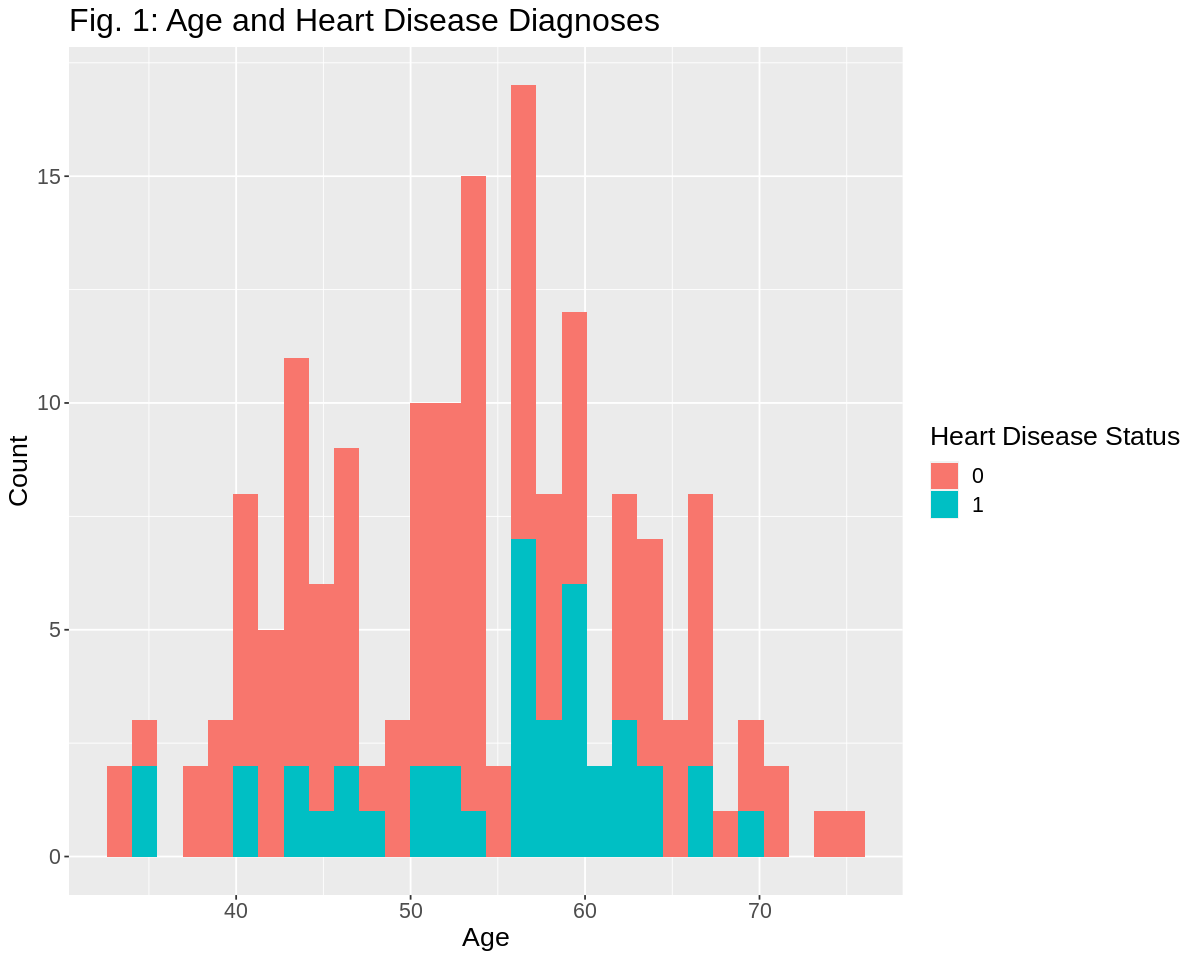

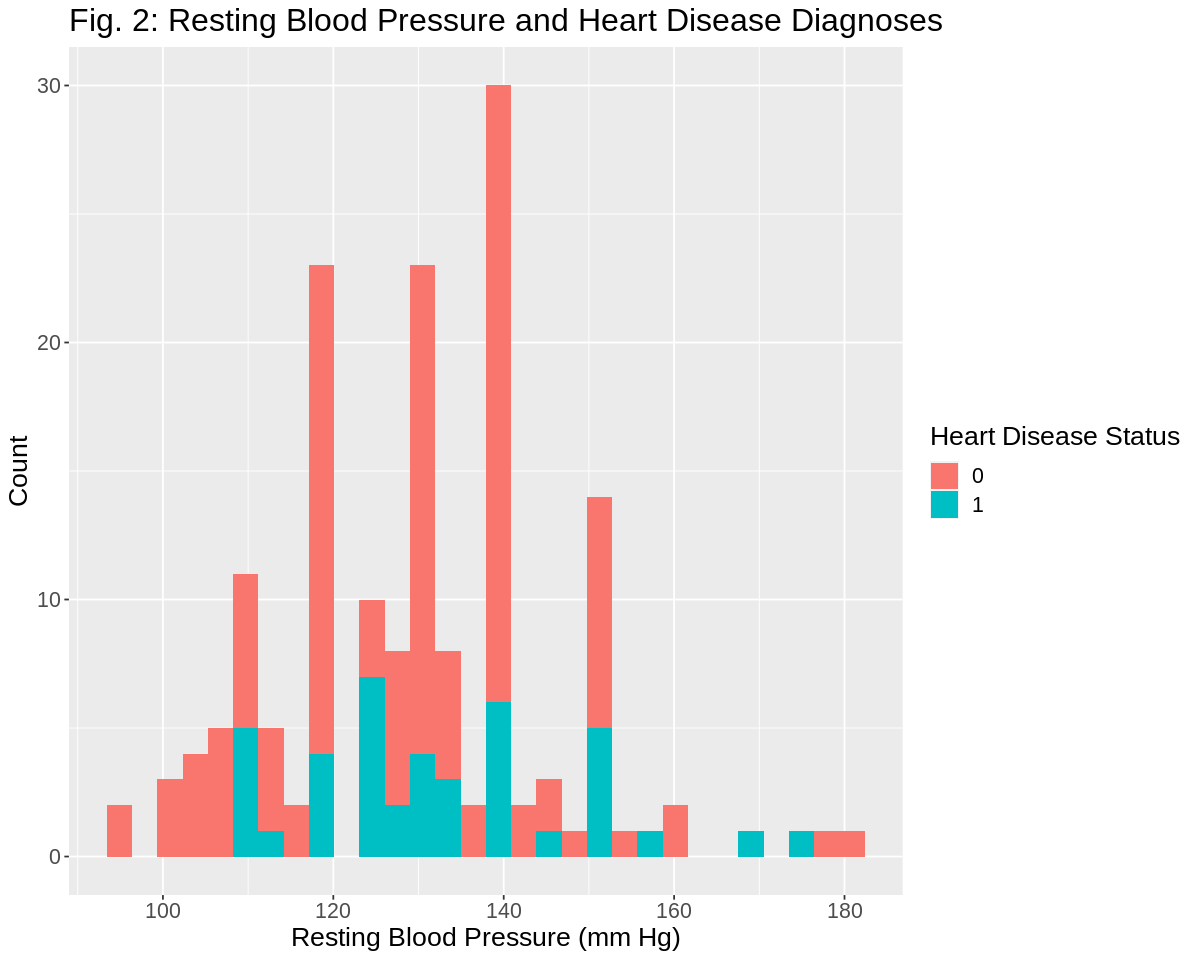

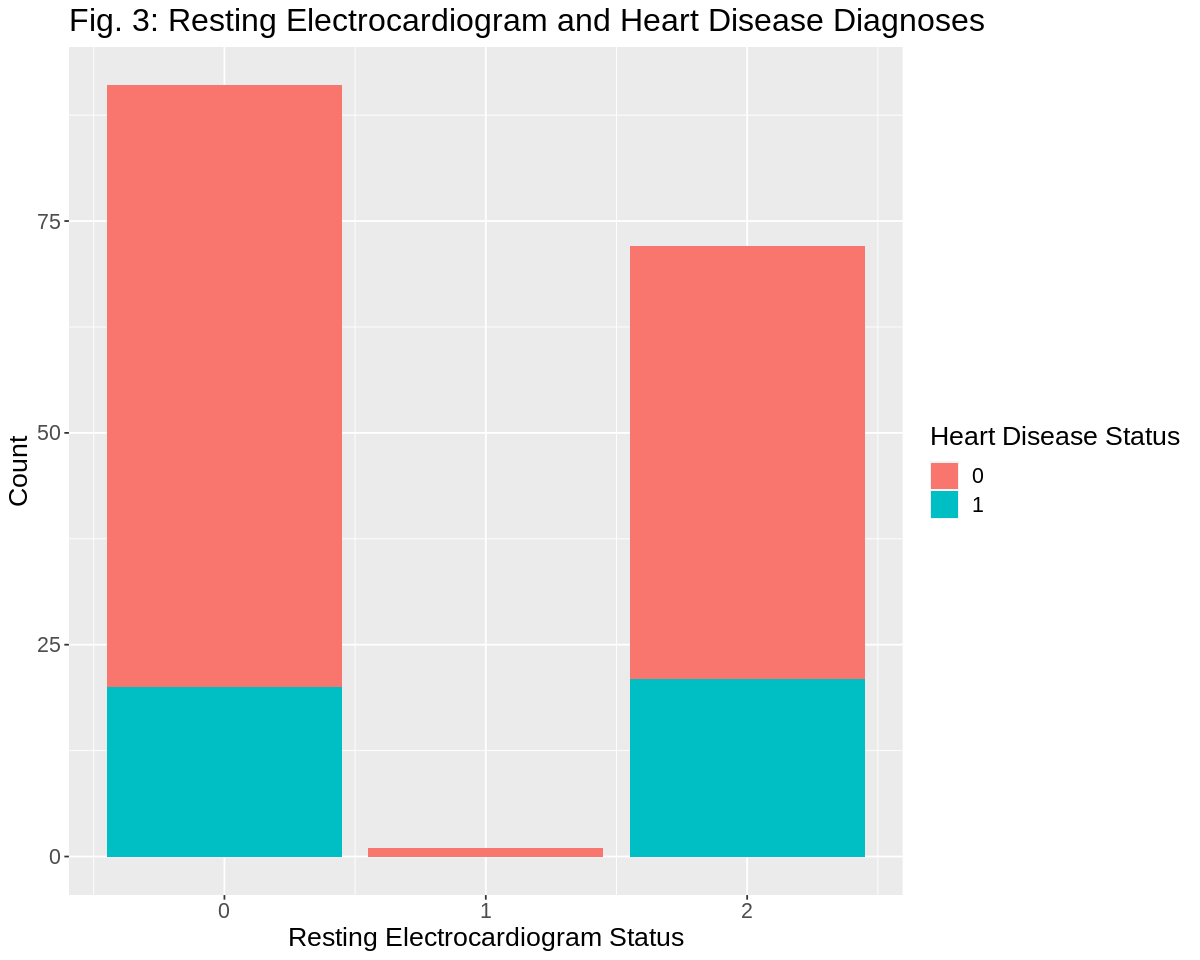

In [9]:
#Creating the plots to visualize the predictors from the first dataset in relation to the severity of heart disease. 
#All the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

resting_age_plot <- ggplot(resting_train, aes(x = age)) +
    ggtitle("Fig. 1: Age and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Age") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
resting_age_plot

resting_bps_plot <- ggplot(resting_train, aes(x = resting_blood_pressure)) +
    ggtitle("Fig. 2: Resting Blood Pressure and Heart Disease Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("Resting Blood Pressure (mm Hg)") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
resting_bps_plot

resting_electro_plot <- ggplot(resting_train, aes(x = resting_electrocardio)) +
    ggtitle("Fig. 3: Resting Electrocardiogram and Heart Disease Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Resting Electrocardiogram Status") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
resting_electro_plot

These plots depict the predictors’ distribution, indicating the association between HD diagnosis and each value. In Fig. 1, ages are 5-75, with most data at ages 50-65. Generally, HD diagnoses increase with age. In Fig. 2, resting blood pressure has a range of ~95-205mmHg, with most data at 105-150mmHg. Diagnoses occur at 110-175mmHg. Finally, in Fig. 3, most observations have a resting ECG status of 0 or 2, with approximately the same number of diagnoses at each. This graphical representation emphasizes the importance of scaling the data for modeling. 

<b>GROUP 2 GRAPHS:</b>

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



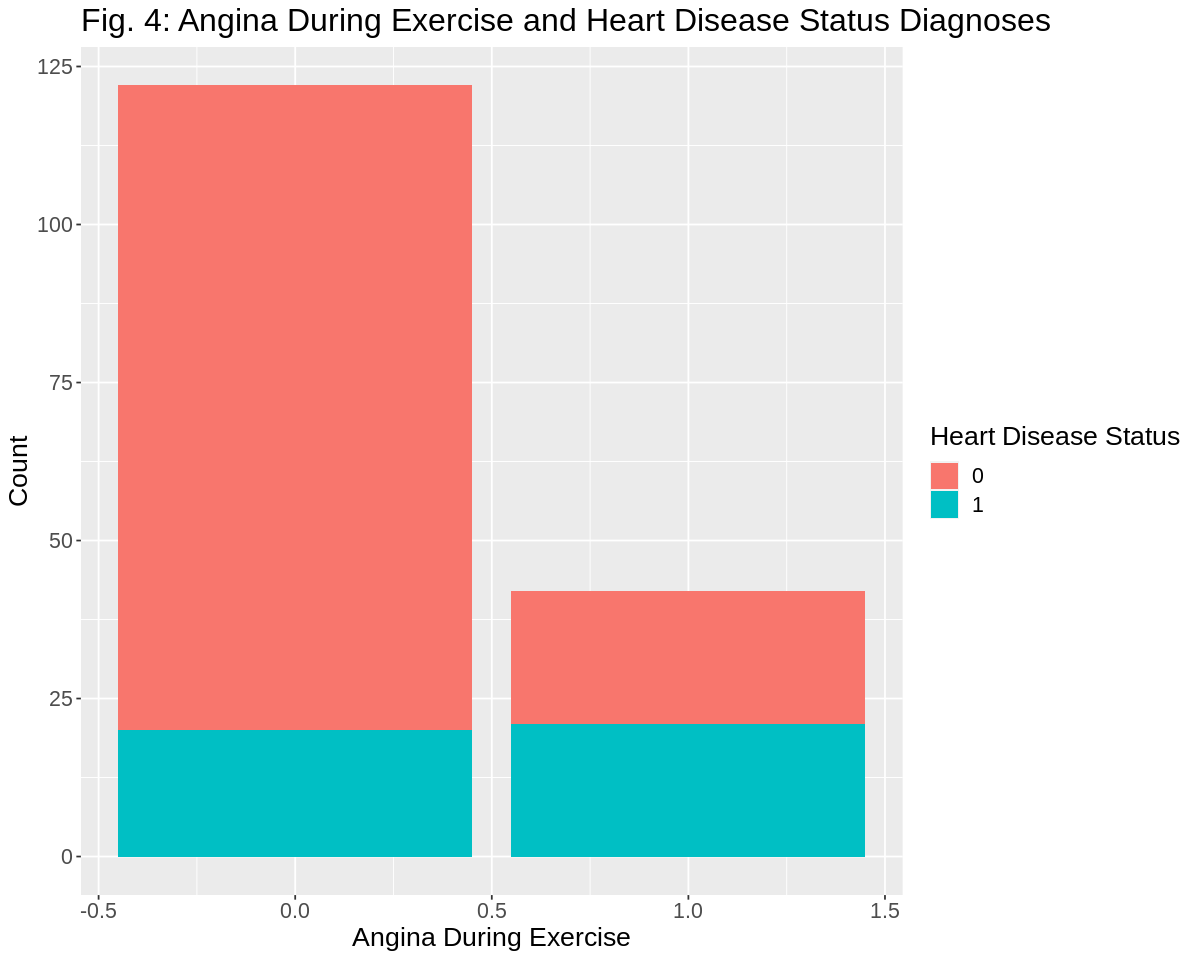

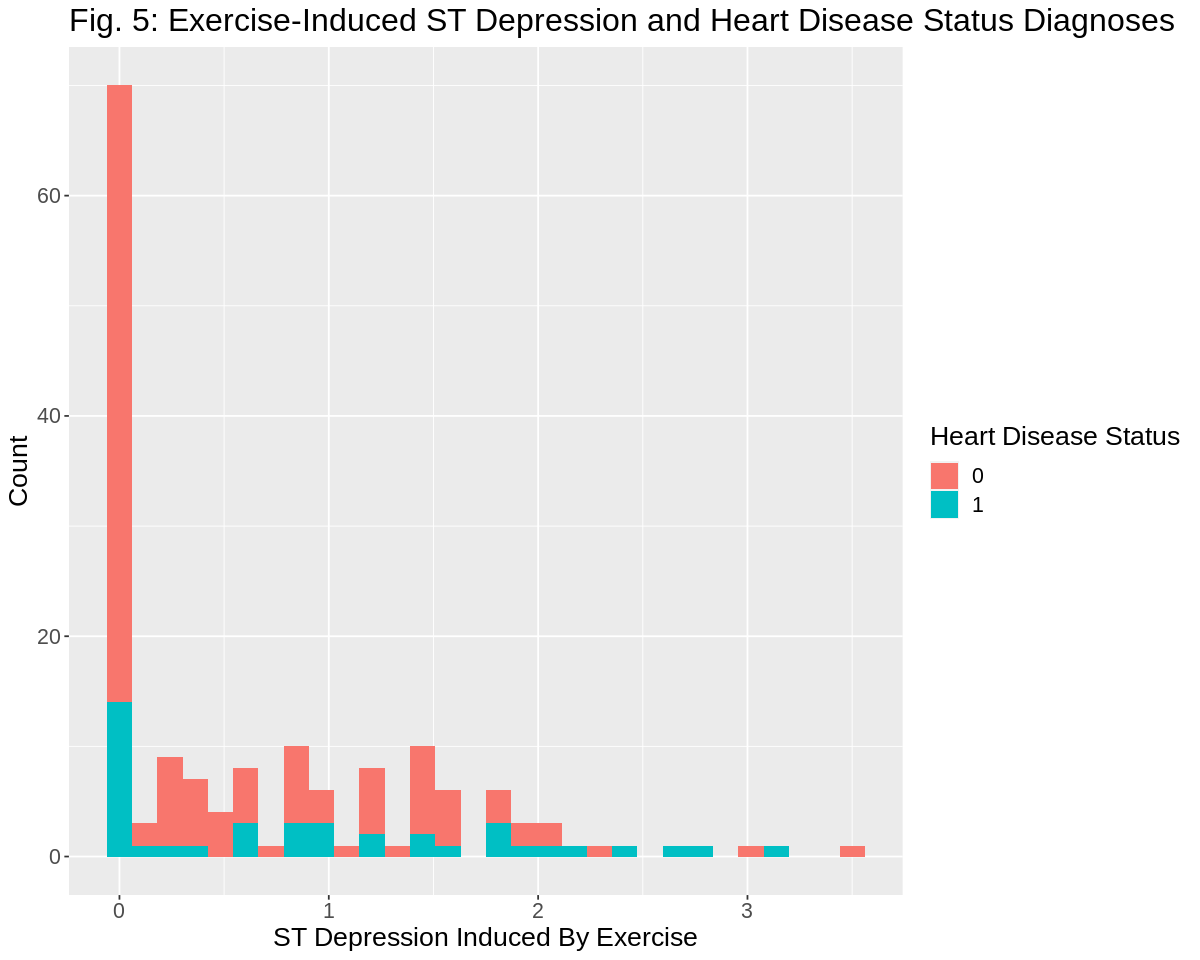

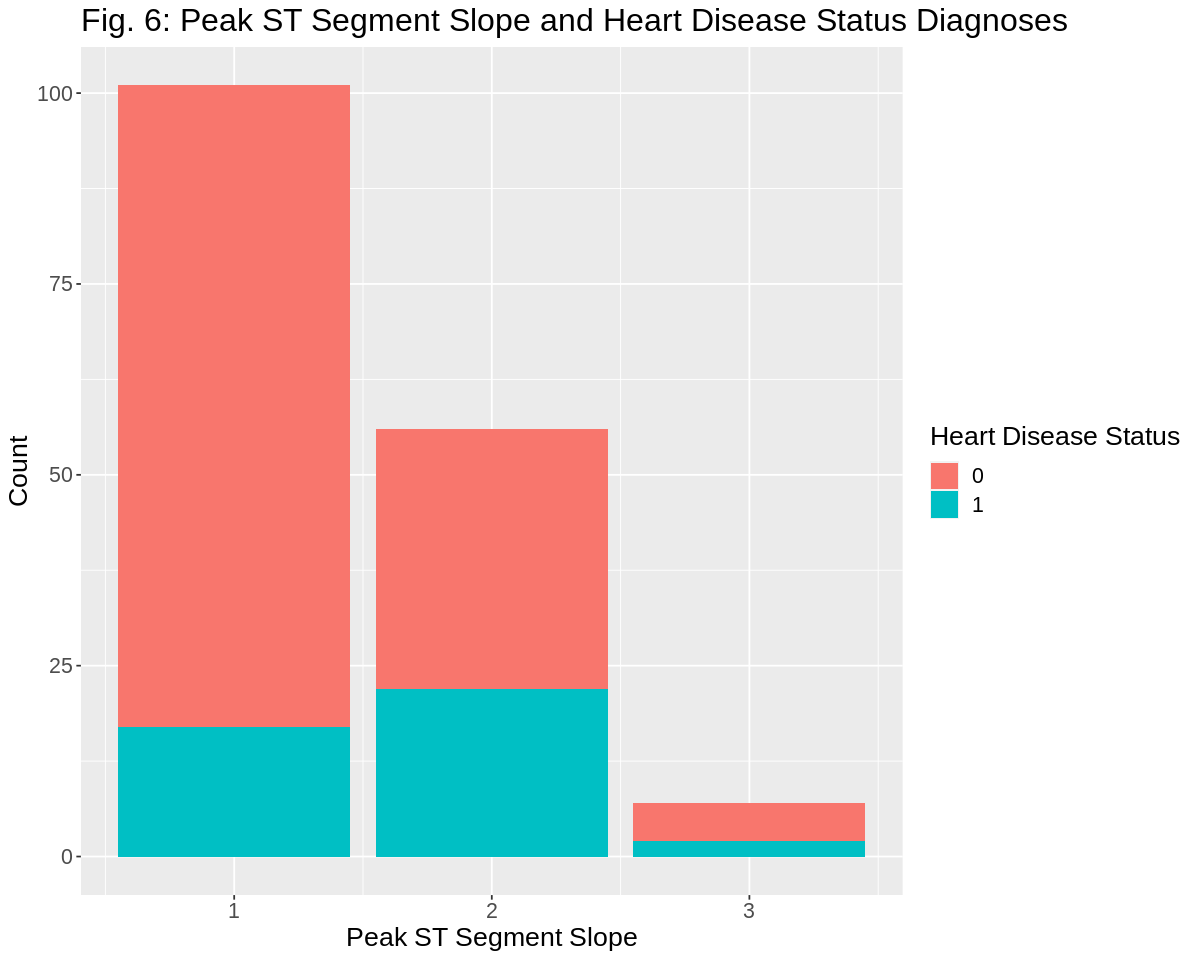

In [10]:
#Creating the plots to visualize the predictors in the second data set in relation to the severity of heart disease.
#All of the titles in the plots and axes names are derived from the descriptions of the variables in (Detrano, n.d.).
options(repr.plot.width = 10, repr.plot.height = 8) 

exercise_angina <- ggplot(exercise_train, aes(x = exercise_angina)) +
    ggtitle("Fig. 4: Angina During Exercise and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Angina During Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
exercise_angina

exercise_st_plot <- ggplot(exercise_train, aes(x = exercise_st)) +

    ggtitle("Fig. 5: Exercise-Induced ST Depression and Heart Disease Status Diagnoses") +
    geom_histogram(aes(fill = result)) +
    xlab("ST Depression Induced By Exercise") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
exercise_st_plot

exercise_slope_plot <- ggplot(exercise_train, aes(x = exercise_slope)) +
    ggtitle("Fig. 6: Peak ST Segment Slope and Heart Disease Status Diagnoses") +
    geom_bar(aes(fill = result)) +
    xlab("Peak ST Segment Slope") +
    ylab("Count") +
    labs(fill = "Heart Disease Status") +
    theme(text = element_text(size = 16))
exercise_slope_plot

These histograms demonstrate the association between our exercise predictors and HD diagnosis. In Fig. 4, exercise angina is binary, associated with values 0 or 1. Mose observations have a 0 value and no HD. Fig. 5 depicts the ST depression during exercise, holding values between 0 and 3.5. The largest proportion is at 0, and the majority have no HD. Finally, in Fig. 6, the peak ST segment slope adopts values of 1, 2, or 3. Most observations are at 1 or 2, and the number of individuals with no HD decreases as the predictor's value increases. These graphs expose our data’s range, allowing us to make preliminary predictions regarding their associated HD diagnosis.

### NON-EXERCISE PREDICTORS MODELING:

Our first model predicts HD using non-exercise predictors, allowing us to determine whether a diagnostic paradigm including these variables will be appropriate. 

We need to determine the number of each diagnosis in our training data to determine if the classes are balanced.

In [11]:
# Determining the number of observations of each result to determine if we need to balance the classes.

number_of_each_result_resting <- resting_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_resting

result,count
<fct>,<int>
0,123
1,41


<i><b>Table 3:</b> No. of observations for each result in resting training set</i>

The varying number of observations associated with each result in the training dataset shows that the classes are not balanced, and we need to do so for modeling.

In [12]:
set.seed(9999)

# Creating a recipe to upsample the data so that we can balance the classes. 
balanced_recipe_resting <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = resting_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_resting_train <- bake(balanced_recipe_resting, resting_train)

This recipe indicates we are classifying the result variable, using our non-exercise predictors, scaling and centering the data so each predictor equally affects the model. 

In [13]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

resting_recipe <- recipe(result ~ age + resting_blood_pressure + resting_electrocardio, data = balanced_resting_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

We specify a classification model, indicating that we are tuning the number of neighbours to find a $K$ with optimal accuracy. 


In [14]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

resting_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

To tune the model, we perform cross-validation on the training dataset, training the model on a portion, and testing it on the validation set, estimating the $K$ values’ accuracy, specified in the tibble. These are included in the workflow to collect the metrics.

In [15]:
set.seed(9999)

# Creating a cross validation set. 

resting_vfold <- vfold_cv(resting_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 1))
                   
# Creating a workflow to determine the best K. 

resting_model_workflow <- workflow() |>
                            add_recipe(resting_recipe) |>
                            add_model(resting_model_tune) |>
                            tune_grid(resamples = resting_vfold, grid = k_to_try) |>
                            collect_metrics()

We plot the $K$ values' accuracy to identify the best $K$ for modeling.

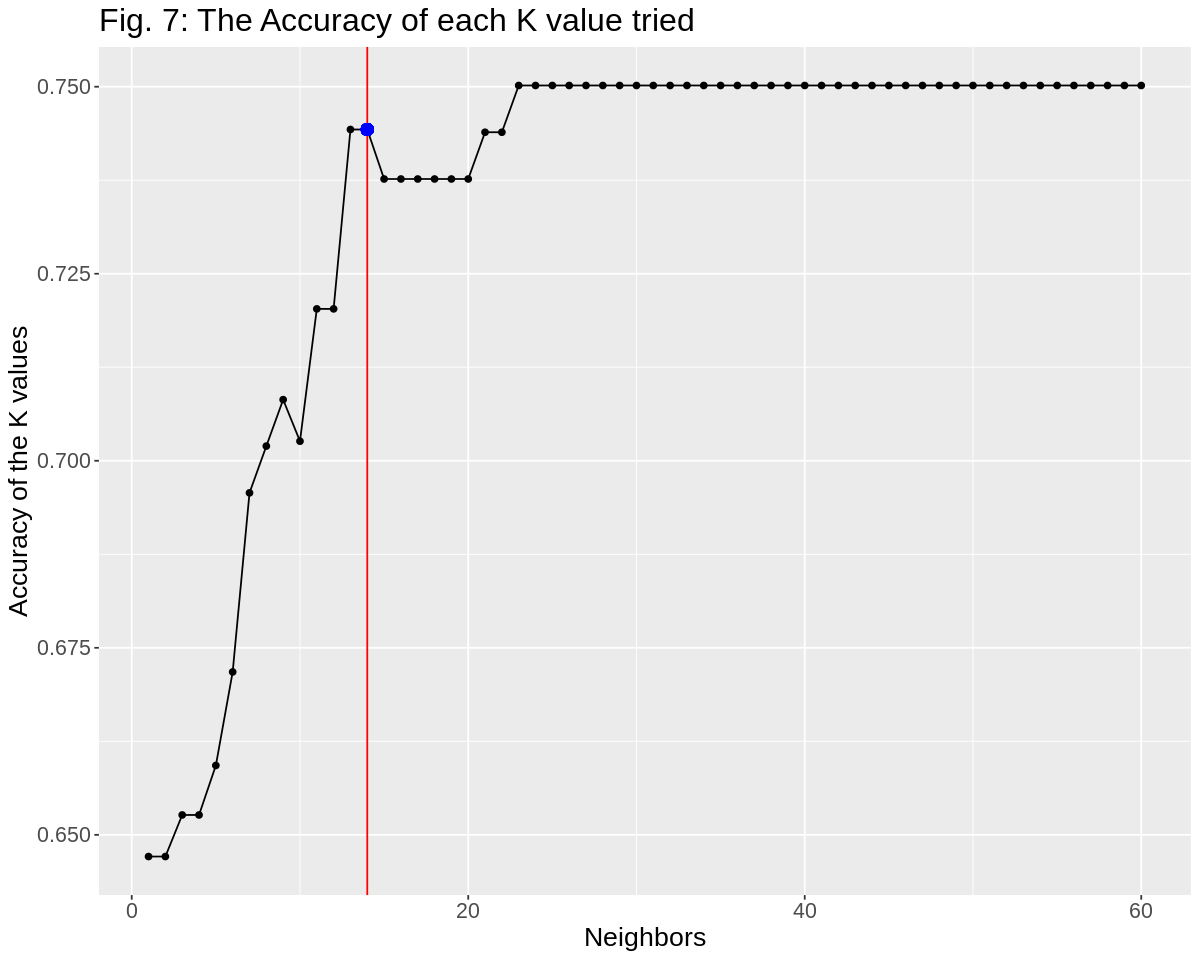

In [31]:
# Filtering the accuracy of each K from the metrics.

accuracy_of_k <- resting_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy_k <- accuracy_of_k|>
                filter(neighbors == 14) |> 
                select(mean) |>
                pull()

accuracy_plot <- accuracy_of_k |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 14, colour = "red") +
                    geom_point(aes(x = 14, y = highest_accuracy_k), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 7: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 16))

accuracy_plot

From the above plot, we choose $K$=14 as it generates the highest accuracy, and its adjacent values are fairly accurate too. 

With the best $K$, we create a new model and fit it to our training data. This trains the model on data it is not tested on so we can achieve a good accuracy estimate.

In [17]:
set.seed(9999)

# Creating a new model which includes the new K to generate the best fit. 

best_resting_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 14) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_resting_fit <- workflow() |>
                        add_recipe(resting_recipe) |>
                        add_model(best_resting_model) |>
                        fit(data = balanced_resting_train)

# Fitting the model to our testing data to make the predictions. 

resting_predictions <- best_resting_fit |>
                        predict(resting_test) |>
                        bind_cols(resting_test)

In [18]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

resting_metrics <- resting_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
resting_metrics

resting_conf_mat <- resting_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
resting_conf_mat

[1] 0.6181818

          Truth
Prediction  0  1
         0 23  3
         1 18 11

<i><b>Table 4:</b> Confusion matrix for resting predictors model </i>

Our resting model provides an accuracy of ~0.62, thus correctly diagnoses 62% of the time. Our majority classifier is the 0 result, and represents ~75% of the data, thus, our model performs worse than it.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



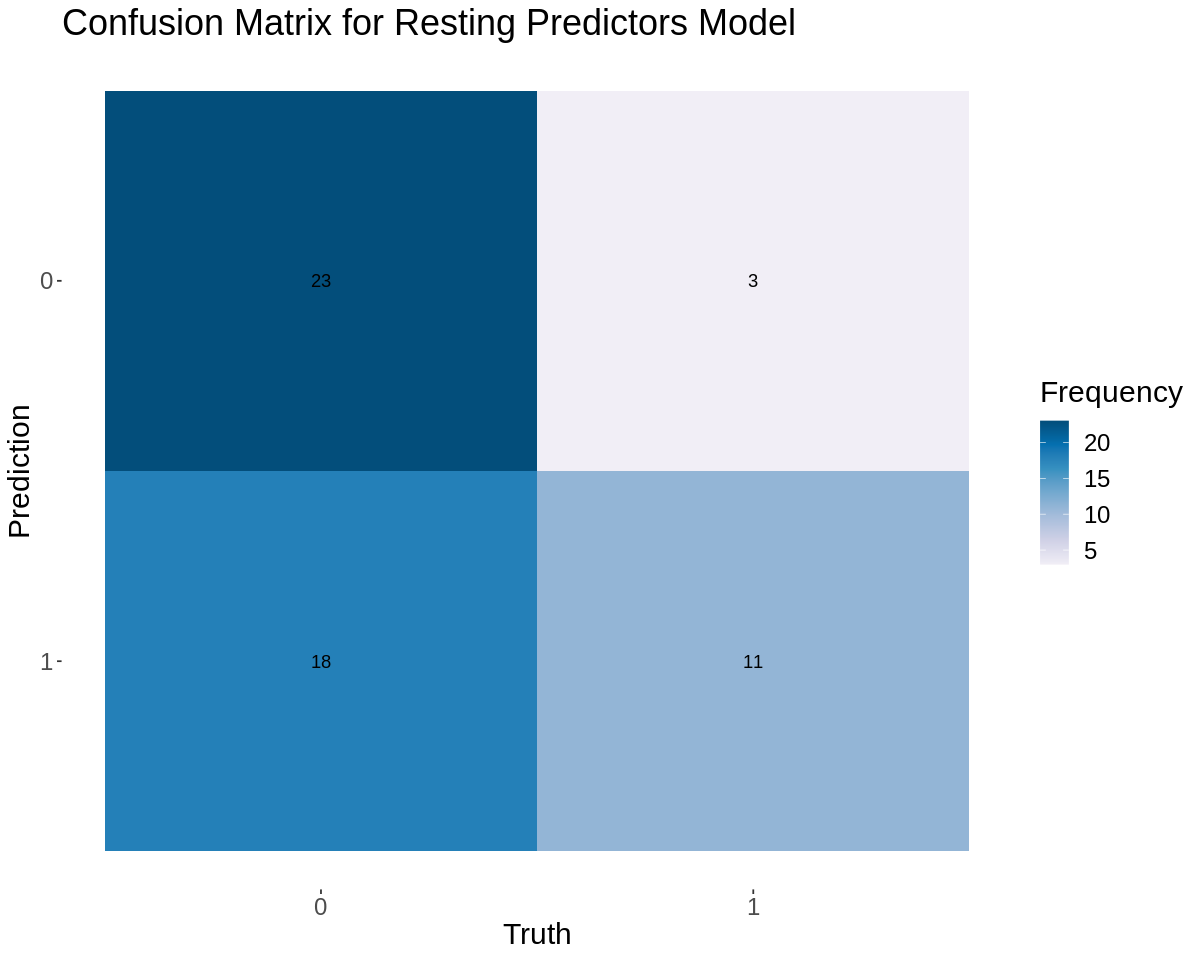

In [33]:
#visualizing the confusion matrix for the resting predictors model

autoplot(resting_conf_mat, type = "heatmap") +
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +        
    labs(title = "Confusion Matrix for Resting Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 18),
          plot.caption = element_text(size = 16, hjust = 0))

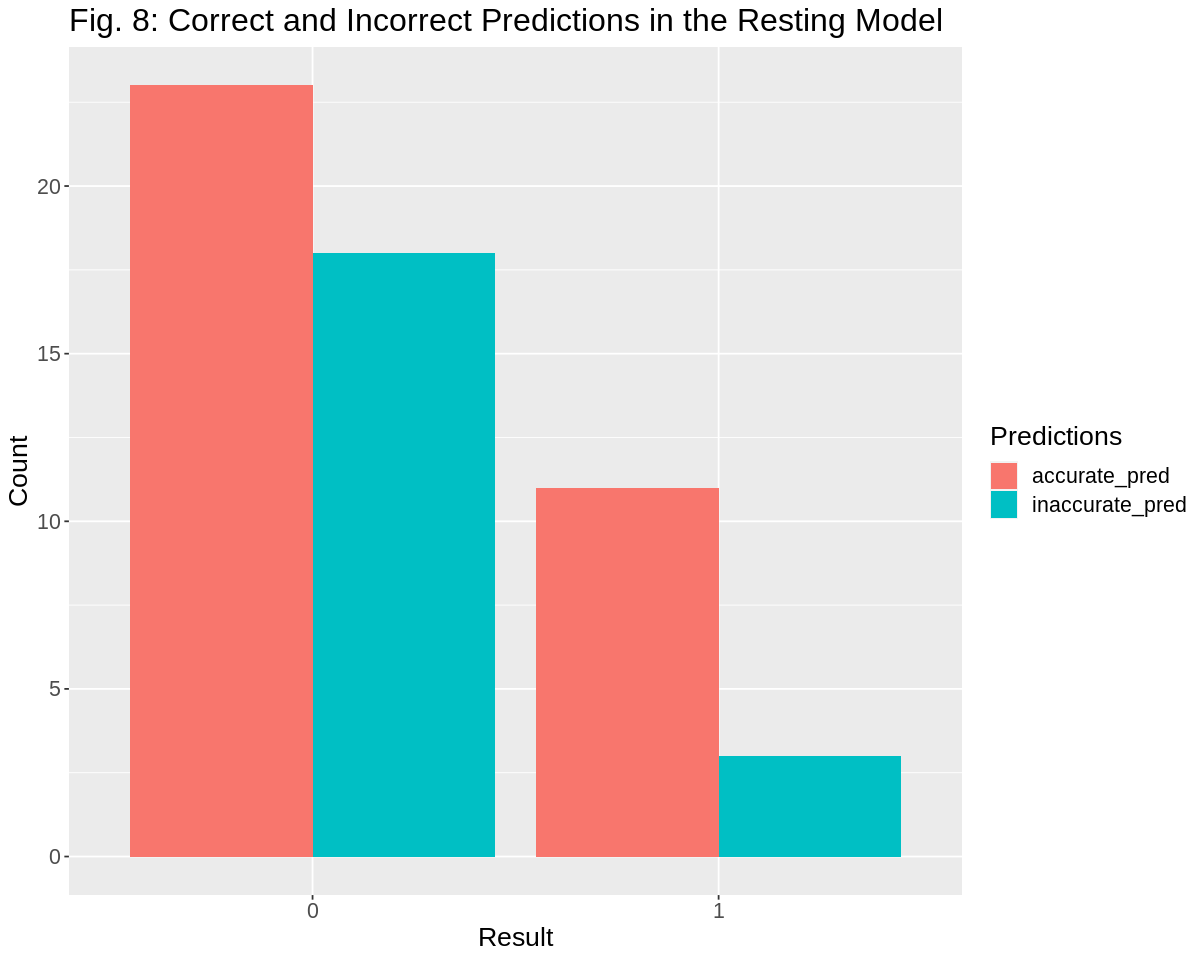

In [20]:
# Making the confusion matrix into a data frame.

resting_pred_accuracy <- resting_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result))
    data_long <- reshape2::melt(resting_pred_accuracy, id.vars = "result")

# Visualizing the confusion matrix as a bar graph. 

resting_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 8: Correct and Incorrect Predictions in the Resting Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

resting_pred_accuracy_plot

Fig. 8 demonstrates the model's correct predictions relative to its incorrect predictions, for each result. It predicts diagnoses more accurately than inaccurately, however, it provides more false positives than it does accurate predictions of presence of HD. HD diagnosis relies on "patient's history, their physical examination, and both laboratory and imaging data" (Olsen et al., 2020) and these should be included in our modeling (Olsen et al., 2020). With this model's predictors, we are restricted to "their physical examination" (Olsen et al., 2020). This explains the model's low accuracy and performance relative to the majority classifier as it does not assess the variety of predictors required (Olsen et al., 2020). Due to the importance of HD diagnosis (Olsen et al., 2020), this model is not clinically appropriate.

### EXERCISE PREDICTORS MODELING:

The next model uses exercise predictors for HD diagnosis. We must determine whether the classes are balanced before modeling.

In [21]:
# Checking the amount of each of the results in our training set to determine if we have to balance the classes.
number_of_each_result_exercise <- exercise_train |>
    group_by(result) |>
    summarize(count = n())
number_of_each_result_exercise

result,count
<fct>,<int>
0,123
1,41


<i><b>Table 5:</b> No. of observations of each result in exercise training set</i>

The number of each result in the training dataset indicates the classes are not balanced, there is more of the 0 result, thus we created a balanced dataset.

In [22]:
set.seed(9999)

# Creating a recipe to upsample the data so that we balance the classes. 
balanced_recipe_exercise <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                                step_upsample(result, over_ratio = 1, skip = FALSE) |>
                                prep()

# Baking this recipe with our training data so that the classes are balanced. 
balanced_exercise_train <- bake(balanced_recipe_exercise, exercise_train)

This recipe scales and centers the data so all predictors contribute equally to the model. It indicates we are predicting for the result variable. 

In [23]:
# Creating a recipe for the classification using the resting data. 
set.seed(9999)

exercise_recipe <- recipe(result ~ exercise_angina + exercise_st + exercise_slope, data = exercise_train) |>
                        step_scale(all_predictors()) |>
                        step_center(all_predictors()) 

In [24]:
# Creating a model for the classification that we can tune to find the best K. 
set.seed(9999)

exercise_model_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                        set_engine("kknn") |>
                        set_mode("classification")

We perform cross-validation to find the best $K$ by determining each $K$ tried's accuracy by testing the $K$ on portions of the training set called validation sets. 

In [25]:
set.seed(9999)

# Creating a cross validation. 

exercise_vfold <- vfold_cv(exercise_train, v = 10, strata = result)

# Creating a subset of K values to try. 

k_to_try <- tibble(neighbors = seq(from = 1, to = 60, by = 1))
                   
# Creating a workflow to determine the best K. 

exercise_model_workflow <- workflow() |>
                            add_recipe(exercise_recipe) |>
                            add_model(exercise_model_tune) |>
                            tune_grid(resamples = exercise_vfold, grid = k_to_try) |>
                            collect_metrics()

Using our cross-validation results we determine the best $K$, by plotting the $K$ tried with respect to their accuracy.

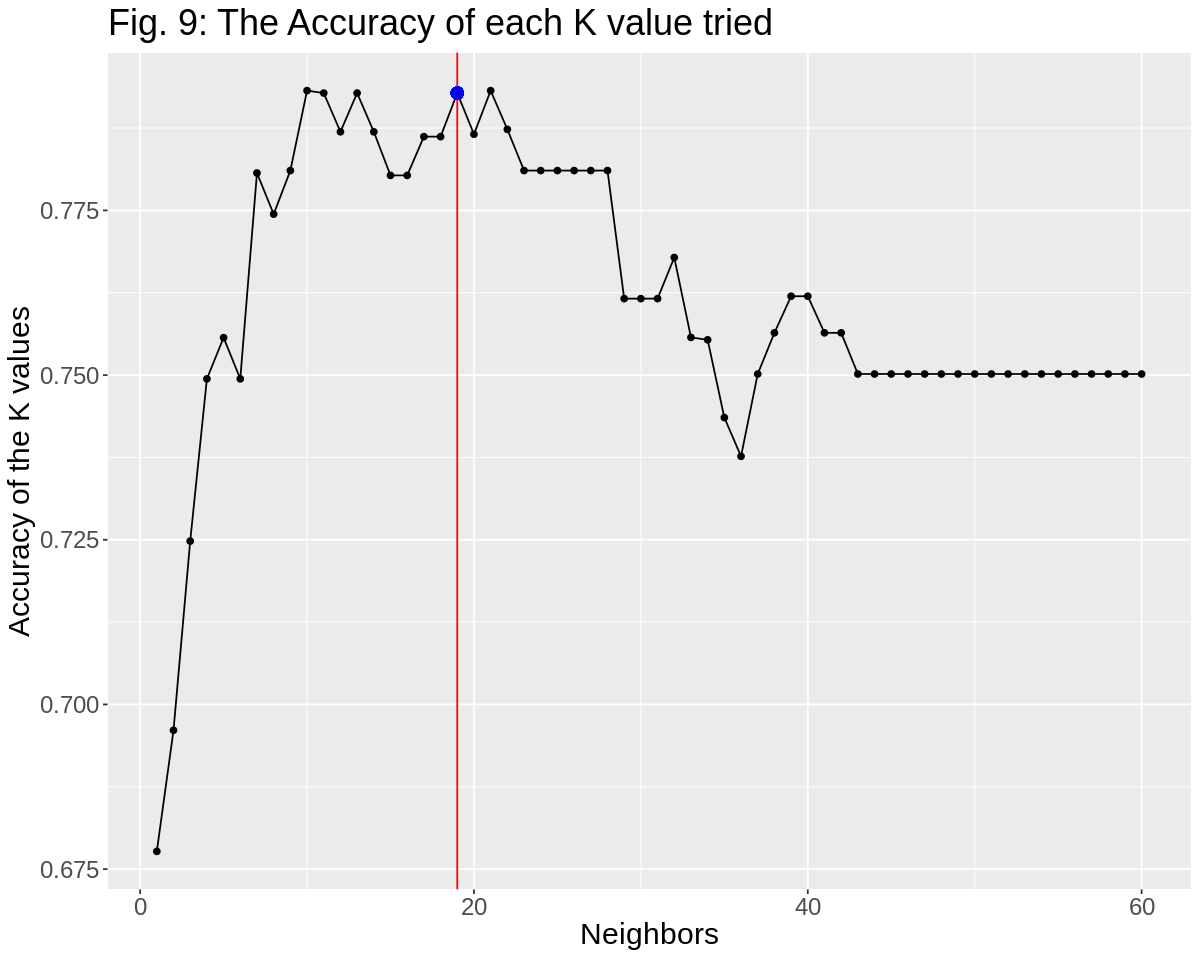

In [26]:
accuracy_of_k_exercise <- exercise_model_workflow |>
                    filter(.metric == "accuracy")

# Making a plot of the accuracy to use to determine the best K for this analysis. 

highest_accuracy <- accuracy_of_k_exercise |>
                filter(neighbors == 19) |> 
                select(mean) |>
                pull()

accuracy_plot_exercise <- accuracy_of_k_exercise |>
                    ggplot(aes(x = neighbors, y = mean)) + 
                    geom_point() +
                    geom_line() +
                    geom_vline(xintercept = 19, colour = "red") +
                    geom_point(aes(x = 19, y = highest_accuracy), size = 3, colour = "blue") +
                    labs(x = "Neighbors", y = "Accuracy of the K values") +
                    ggtitle("Fig. 9: The Accuracy of each K value tried") +
                    theme(text = element_text(size = 18))

accuracy_plot_exercise

From the above plot, we will choose $K$=19 as its accuracy is highest with fairly accurate adjacent values too.

Thus, we use this $K$ in a model fit to our training data, to predict the testing data's results.

In [27]:
set.seed(9999)

# Creating a new model which includes the K to generate the best fit. 

best_exercise_model <- nearest_neighbor(weight_func = "rectangular", neighbors = 19) |>
                        set_engine("kknn") |>
                        set_mode("classification") 

# Creating a workflow to fit the best model to our training data to train the model. 

best_exercise_fit <- workflow() |>
                        add_recipe(exercise_recipe) |>
                        add_model(best_exercise_model) |>
                        fit(data = balanced_exercise_train)

# Fitting the model to our testing data to make the predictions. 

exercise_predictions <- best_exercise_fit |>
                        predict(exercise_test) |>
                        bind_cols(exercise_test)

Through analyzing the metrics and confusion matrix we can determine this model's success at predicting the testing data's classes.

In [28]:
set.seed(9999)

# Looking at the metrics and confusion matrix for this model to determine its accuracy.

exercise_metrics <- exercise_predictions |>
                    metrics(truth = result, estimate = .pred_class) |>
                    filter(.metric == "accuracy") |>
                    select(.estimate) |>
                    pull()
exercise_metrics

exercise_conf_mat <- exercise_predictions |>
                    conf_mat(truth = result, estimate = .pred_class)
exercise_conf_mat

[1] 0.7454545

          Truth
Prediction  0  1
         0 37 10
         1  4  4

<i><b>Table 6:</b> Confusion matrix for exercise predictors model</i>

This model has an accuracy of ~0.75, indicating that 75% of its predictions are correct. The majority classifier is the 0 result and its accuracy is 75%, thus our model is equivalent to that, yet is more accurate than the non-exercise model. Due to its innacuracy, it is likely clinically insufficient too.

Scale for 'fill' is already present. Adding another scale for 'fill', which
will replace the existing scale.



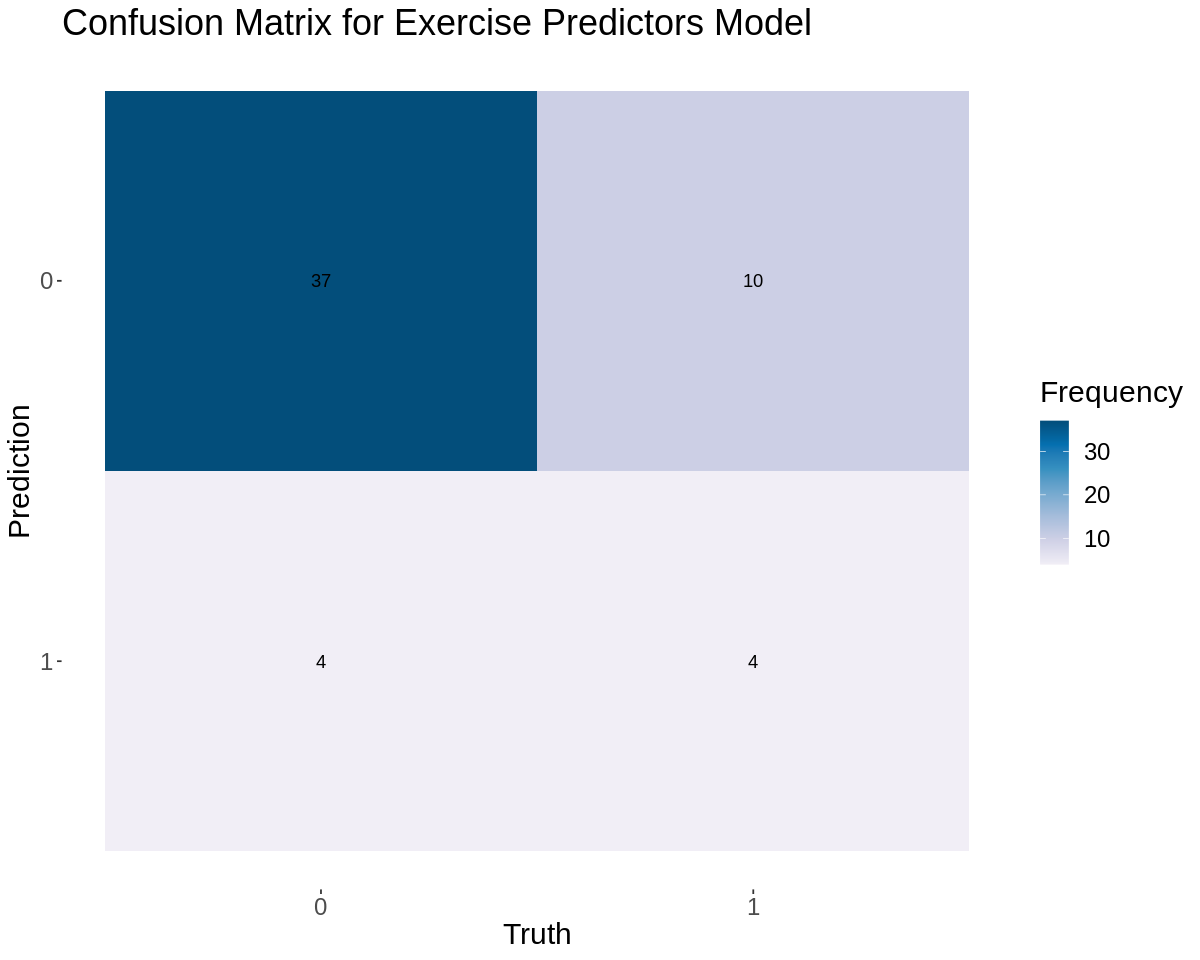

In [29]:
#visualizing the confusion matrix for the exercise predictors model

autoplot(exercise_conf_mat, type = "heatmap") +
    scale_fill_distiller(palette = "PuBu", direction = 1, name = "Frequency") +       
    labs(title = "Confusion Matrix for Exercise Predictors Model") +
    theme(legend.position = "right", text = element_text(size = 18),
          plot.caption = element_text(size = 16, hjust = 0))

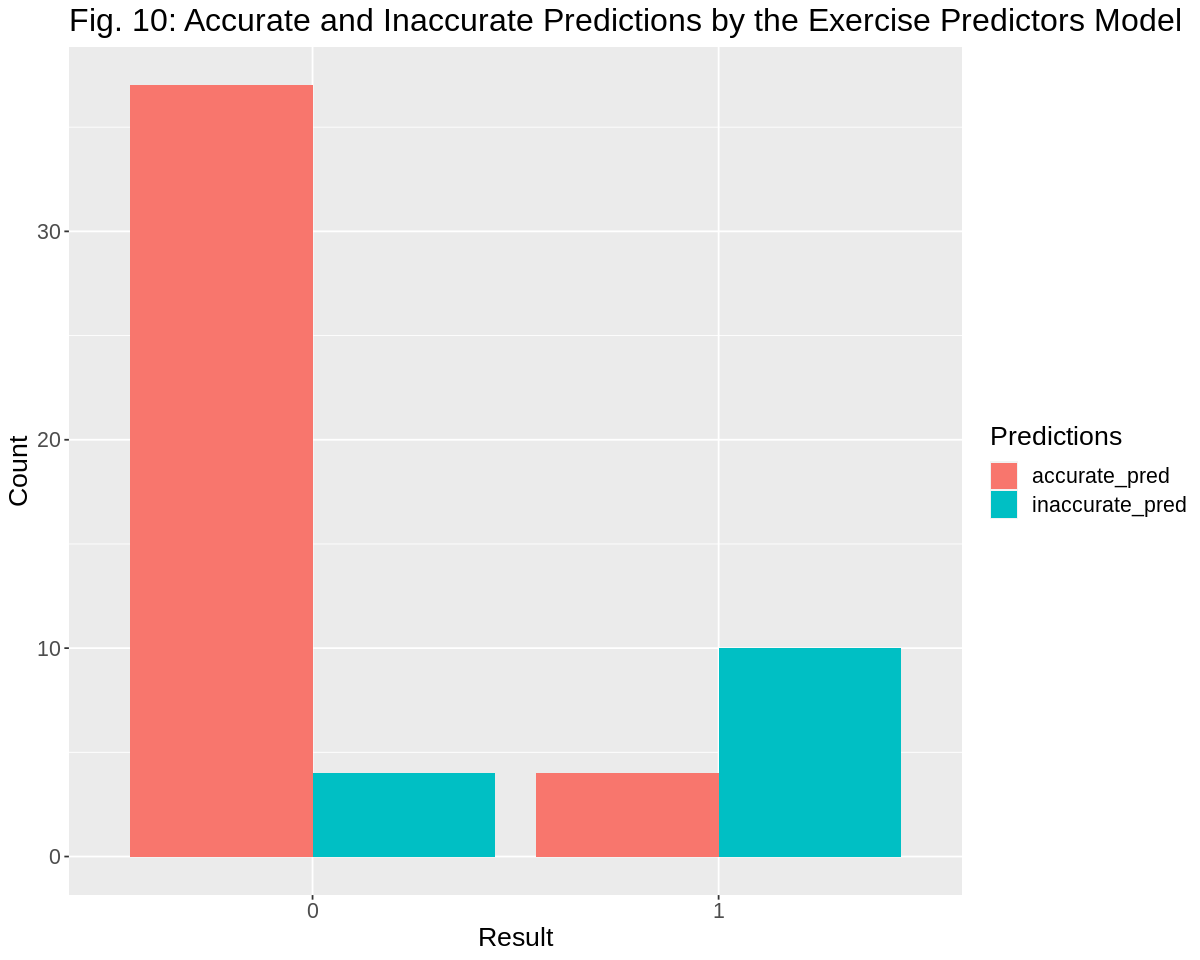

In [30]:
# Making a data frame from the confusion matrix data.
exercise_pred_accuracy <- exercise_predictions |>
    group_by(result)|> 
    summarize(accurate_pred = sum(.pred_class == result), inaccurate_pred = sum(.pred_class != result))
    data_long <- reshape2::melt(exercise_pred_accuracy, id.vars = "result")

# Visualizing the confustion matrix as a bar graph. 
exercise_pred_accuracy_plot <- ggplot(data_long, aes(x = result, y = value, fill = variable)) +
    ggtitle("Fig. 10: Accurate and Inaccurate Predictions by the Exercise Predictors Model") +
    geom_bar(stat="identity", position = "dodge") +
    labs(x = "Result", y = "Count", fill = "Predictions")+
    theme(text = element_text(size = 16))

exercise_pred_accuracy_plot

Fig. 10 identifies this model's accurate predictions compared to its inaccurate predictions. It correctly predicts no HD more than incorrectly, however correctly diagnoses HD less than incorrectly. To diagnose HD clinically, we require analysis of predictors spanning a range of categories, that our model should also reflect (Olsen et al., 2020). However we have limited ourselves to "their physical examination" (Olsen et al., 2020), explaining our model's poor accuracy. 

Exercise testing, otherwise known as stress tests, are important to diagnose HD as they force the individual's heart to pump blood hard, and thus be working rapidly (Harvard Health Publishing, 2020). While the results of an exercise test alone are not completely accurate in diagnosing HD, clinically, they are coupled with risk factors such as age and cholesterol levels to perform the diagnosis (Harvard Health Publishing), thus explaining our exercise model's higher accuracy than the non-exercise model.

### Discussion:


<b>References:</b>

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Bösner, S., Becker, A., Hani, M.A., Keller, H., Sönnichsen, A.C., Haasenritter, J., Karatolios, K., Schaefer, J.R., Baum, E., and Donner-Banzhoff, N. (2010). Accuracy of Symptoms and Signs for Coronary Heart Disease Assessed in Primary Care. British Journal of General Practice, 60(575), 246-257. 10.3399/bjgp10X502137

DataScience Made Simple. (2023). Case When in R Using case_when() Dplyr - case_when in R. DataScience Made Simple. https://www.datasciencemadesimple.com/case-statement-r-using-case_when-dplyr/.  

Detrano, R. (n.d.). processed.cleveland.set [Data set]. UCI Machine Learning 
Repository. https://archive.ics.uci.edu/ml/datasets/Heart+Disease

Finkelhor, R.S., Newhouse, K.E., Vrobel, T.R., Miron, S.D., and Bahler, R.C. (1986). The ST Segment/Heart Rate Slope as a Predictor of Coronary Artery Disease: Comparison with Quantitative Thallium Imaging and Conventional ST Segment Criteria. American Heart Journal. 112(2). 296-304. https://doi.org/10.1016/0002-8703(86)90265-6

Harvard Health Publishing. (2021, September 21). Angina: Symptoms, diagnosis and treatments. Harvard Medical School. https://www.health.harvard.edu/heart-health/angina-symptoms-diagnosis-andtreatments#:~:text=September%2021%2C%202021,by%20cholesterol%2Dclogged%20coronary%20arteries.

Harvard Health Publishing. (2020, April 15). Cardiac exercise stress testing: What it can and cannot tell you. Harvard Medical School. https://www.health.harvard.edu/heart-disease/cardiac-exercise-stress-testing-what-it-can-and-cannot-tell-you.

Lanza, G.A., Mustilli, M., Sestito, A., Infusino, F., Sgueglia, G.A., and Crea, F. (2004). 
Diagnostic and Prognostic Value of ST Segment Depression Limited to the Recovery Phase of Exercise Stress Test. Heart. 90(12). 1417-1421. 10.1136/hrt.2003.031260


Olsen, C.R., Mentz, R.J, Anstrom, K.J., Page, D., and Patel, P.A. (2020). Clinical Applications of Machine Learning in the Diagnosis, Classification, and Prediction of Heart Failure. American Heart Journal, 229. 1-17. https://doi.org/10.1016/j.ahj.2020.07.009


Shin, J., Ham, D., Shin, S., Choi, S.K., Paik, H-Y., and Joung, H. (2019). Effects of 
Lifestyle-Related Factors on Ischemic Heart Disease According to Body Mass Index and Fasting Blood Glucose Levels in Korean Adults. PLoS ONE, 14(5), https://doi.org/10.1371/journal.pone.0216534

Wu, C-Y., Hu, H-Y., Chou, Y-J., Huang, N., Chou, Y-C., Li, C-P. (2015). High Blood Pressure 
and All-Cause and Cardiovascular Disease Mortalities in Community-Dwelling Older Adults. Medicine (Baltimore). 94(47). 10.1097/MD.0000000000002160
